In [1]:
%pylab inline

from __future__ import division, print_function
from numpy import array, pi, exp, sqrt, log, max, argmin, cos, sin
from scipy.interpolate import interp1d

from aircraft_design import atmosphere, find_cl_max

DEG2RAD = 0.017453292519943295

Populating the interactive namespace from numpy and matplotlib


#Aircraft Sizing, Synthesis and Integration Support Tool (ASSIST)

##References
* Mattingly, J. D., Heiser, W. H., and Daley, D. H., "Aircraft Engine Design," AIAA Education Series, AIAA, New York, NY, 1987.
* Raymer, D. P., "Aircraft Design: A Conceptual Approach," 3rd ed., AIAA Education Series, AIAA, Reston, VA, 1999.
* Roskam, J., "Airplane Design: Part I-VIII." DARcorporation, Lawrence, KS, 2006.

In [2]:
AR_VS_MACH = {'jet_trainer': [4.737, -0.979],
              'jet_fighter': [5.416, -0.622],
              'jet_attack':  [4.110, -0.622],
              'mil_cargo':   [5.570, -1.075],
              'bomber':      [5.570, -1.075],
              'transport':   [7.500,  0.000]}

In [3]:
find_cl_max(flap_type='triple_slotted',
            configuration='landing',
            slats=True,
            k_aero=0.75,
            sweep=30,
            flap_span=[0.2, 0.4],
            taper_ratio=0.2)

1.7196940257353017

In [2]:
class MissionSegment(object):
    """
    Aircraft mission
    
    """
    WEIGHT_FRACTIONS = dict(warmup=0.99,
                            taxi=0.99,
                            takeoff=0.98,
                            climb=0.95,
                            descend=0.98,
                            land=0.99)
    
    def __init__(self, name, speed, altitude,
                 density_sl=0.002378,
                 temperature_sl=516.17,
                 g_0=32.2,
                 *args, **kwargs):

        self.name = name
        if 'weight_fraction' not in kwargs and name in self.WEIGHT_FRACTIONS:
            self.weight_fraction = self.WEIGHT_FRACTIONS[name]
        else:
            self.weight_fraction = kwargs.pop('weight_fraction', 1.0)
        
        self.altitude = altitude
        
        rho, temp, self.speed_of_sound = atmosphere(altitude, density_sl, temperature_sl)
        self.density = rho if 'density' not in kwargs else kwargs['density']
        self.temperature = temp if 'temperature' not in kwargs else kwargs['temperature']

        if speed is not None:
            self.speed = speed * 1.68780986  # kts to ft/s
            self.mach = self.speed / self.speed_of_sound
        
        self.g_0 = g_0
        self.n = 1
        if 'turn_rate' in kwargs:
            turn_rate = kwargs.pop('turn_rate')
            self.n = sqrt(1 + (turn_rate * self.speed / g_0) ** 2)
        if 'turn_radius' in kwargs:
            turn_radius = kwargs.pop('turn_radius')
            n = sqrt(1 + (self.speed / turn_radius / g_0) ** 2)
            if hasattr(self, 'n'):
                self.n = max(n, self.n)
        
        self.climb_rate = kwargs.pop('climb_rate', 0)
        self.acceleration = kwargs.pop('acceleration', 0)
        
        self.dynamic_pressure = 0.5 * self.density * self.speed * self.speed
        
        if 'land' in self.name:
            self.field_length = kwargs.pop('field_length', 6500)
            self.approach_speed = sqrt(self.field_length / 0.3) * 6076.1154856 / 3600
            

        elif self.name == 'takeoff':
            self.takeoff_ground_roll = kwargs.pop('takeoff_ground_roll', 1500)
            self.obstacle_height = kwargs.pop('obstacle_height', 100)
            
    def cruise(self, aircraft, alpha, q, wing_loading, **kwargs):
        return q * cd_0 / (alpha * wing_loading)
    
    def climb(self, alpha, beta, k_1, k_2, cd_0, cl, speed, climb_rate, **kwargs):
        return (beta / alpha) * (k_1 * cl + k_2 + cd_0 / cl + climb_rate / speed)
    
    def turn(self, alpha, beta, k_1, k_2, cd_0, cl, n, **kwargs):
        return (beta / alpha) * (k_1 * cl * n * n + k_2 * n + cd_0 / c_l)
    
    def land(self):
        raise NotImplementedError()

    def thrust_to_weight_required(self, aircraft, wing_loading):
        cd_0 = aircraft.cd_0
        k_1 = aircraft.k_1
        k_2 = aircraft.k_2
        # TODO: calculate C_DR as a function of mission segment
        cd_r = aircraft.cd_r
        
        alpha = aircraft.thrust_lapse(self.altitude, self.mach)        
        beta = self.weight_fraction
        
        if self.name == 'land':
            aircraft.configuration = 'landing'
            
            wing_loading
            
        if self.name == 'takeoff':
            aircraft.configuration = 'takeoff'
            k_to = aircraft.k_to
            return (beta * beta / alpha) * k_to * k_to * wing_loading / \
                   (self.takeoff_ground_roll * self.density * self.g_0 * aircraft.cl_max)
            
        aircraft.configuration = None
        
        q = self.dynamic_pressure
        c_l = self.n * beta * wing_loading / q
        excess_power = self.climb_rate / self.speed + self.acceleration / self.g_0
        
        return (beta / alpha) * (q / (beta * wing_loading) * (k_1 * c_l * c_l + k_2 * c_l + cd_0 + cd_r) + excess_power)

In [3]:
class Engine(object):
    TYPES = dict(ATJ= {'alpha': [ 1, 1.00, 0.952, 0.30,  0.40,  2.0, 0.7], 'name': 'Advanced Turbo-Jet (with afterburner)'},
                 ATP= {'alpha': [ 1, 0.12, 0.000, 1.00, -0.02, -1.0, 0.5], 'name': 'Advanced Turbo-Prop'},
                 HBTF={'alpha': [-1, 1.00, 0.568, 0.25, -1.20,  3.0, 0.6], 'name': 'High By-Pass Turbo-Fan'},
                 LBTF={'alpha': [ 1, 1.00, 0.940, 0.38,  0.40,  2.0, 0.7], 'name': 'Low By-Pass Turbo-Fan (with afterburner)'})
    
    def __init__(self, engine_type='ATJ',
                 max_thrust=None,
                 max_mach=None,
                 afterburner=False,
                 bpr=1.0,
                 k_sfc=1.0,
                 k_w=1.0,
                 k_size=1.0, *args, **kwargs):
        
        self.engine_type = engine_type
        self.afterburner = afterburner
        self.bpr = bpr
        self.k_sfc = k_sfc
        self.k_w = k_w
        self.k_size = k_size
        
        if bpr < 2.0 and engine_type == 'HBTF':
            raise ValueError("High By-Pass Turbo-Fans must have by-pass ratios greater than 2.0, not {}".format(self.bpr))
        elif bpr > 2.0 and engine_type == 'LBTF':
            raise ValueError("Low By-Pass Turbo-Fans must have by-pass ratios less than 2.0, not {}".format(self.bpr))
        
        self.max_mach = max_mach
        self.max_thrust = max_thrust

        if engine_type not in self.TYPES:
            raise ValueError("Engine type must be one of these {}, not {}".format(self.TYPES.keys(), configuration))

        self.alphas = self.TYPES[engine_type]['alpha']
        self.name = self.TYPES[engine_type]['name']
        
    def __repr__(self):
        return "<{}>".format(self.name)
    
    def size(self):
        """
        Determines a jet engine's parameters based on Raymer's rules as defined in:

        Raymer, D. P., "Aircraft design: a conceptual approach", 3rd Ed., pp. 235

        .. note::
            Cruise is assumed to be at approximately 36,000 ft (11,000 m) and 0.9 Mach
        
        """
        
        if self.afterburner:
            if self.bpr > 1.0:
                raise(NotImplementedError("BPR must be less than 1.0 for afterburning engines, bpr = {}".format(self.bpr)))
            self.w = 0.063 * (self.max_thrust ** 1.1) * (self.max_mach ** 0.25) * exp(-0.81 * self.bpr)
            self.l = 0.255 * (self.max_thrust ** 0.4) * (self.max_mach ** 0.2)
            self.d = 0.024 * (self.max_thrust ** 0.5) * exp(0.04 * self.bpr)
            self.sfc_max = 2.1 * exp(-0.12 * self.bpr)
            self.t_cruise = 2.4 * (self.max_thrust ** 0.74) * exp(0.023 * self.bpr)
            self.sfc_cruise = 1.04 * exp(-0.186 * self.bpr)
        else:
            self.w = 0.084 * (self.max_thrust ** 1.1) * exp(-0.045 * self.bpr)
            self.l = 0.185 * (self.max_thrust ** 0.4) * (self.max_mach ** 0.2)
            self.d = 0.033 * (self.max_thrust ** 0.5) * exp(0.04 * self.bpr)
            self.sfc_max = 0.67 * exp(-0.12 * self.bpr)
            self.t_cruise = 0.60 * (self.max_thrust ** 0.9) * exp(0.02 * self.bpr)
            self.sfc_cruise = 0.88 * exp(-0.05 * self.bpr)

    def thrust_lapse(self, altitude, mach):
        a = self.alphas

        density_ratio, _, _ = atmosphere(altitude, rho_sl=1)

        return a[1] * (a[2] + a[3] * (a[0] * mach - a[4]) ** a[5]) * density_ratio ** a[6]

In [9]:
class Aircraft(object):
    """
    
    
    :param sweep: sweep of the wing at the quarter-chord
    :type sweep: list, tuple, float
    
    """
    
    _CD_0 = {'jet_fighter': {'mach': [  0.0,   0.8,    0.9,    1.1,   1.2,   2.0],
                             'min':  [0.014, 0.014, 0.0160, 0.0260, 0.028, 0.028],
                             'max':  [0.018, 0.018, 0.0235, 0.0345, 0.040, 0.038]}}
    
    _K_1 = {'jet_fighter': {'mach':  [  0.0,   0.8,   1.0,   1.2,   2.0],
                            'min':   [0.180, 0.180, 0.180, 0.216, 0.360],
                            'max':   [0.140, 0.140, 0.170, 0.200, 0.500]}}
    
    CONFIGURATIONS = ('takeoff', 'landing')
    
    CL_MAX = {'plain':          {'takeoff': [1.4, 1.6], 'landing': [1.7, 2.0]},
              'single_slot':    {'takeoff': [1.5, 1.7], 'landing': [1.8, 2.2]},
              'fowler':         {'takeoff': [2.0, 2.2], 'landing': [2.5, 2.9]},
              'double_slotted': {'takeoff': [1.7, 2.0], 'landing': [2.3, 2.7]},
              'triple_slotted': {'takeoff': [1.8, 2.1], 'landing': [2.7, 3.0]},
              'slat':           {'takeoff': 0.6,        'landing': 0.5}}
    
    def __init__(self, 
                 aircraft_type='jet_fighter',
                 configuration=None,
                 engine='ATJ',
                 num_engines=1,
                 flaps='plain',
                 slats=False,
                 cd_r=0.005,
                 k_aero=0.5,
                 k_2=0.003,
                 k_to=1.1,
                 ar=8,
                 sweep=30,
                 *args, **kwargs):

        self.type = aircraft_type
        self.configuration = configuration
        self.flaps = flaps
        self.engine = Engine(engine) if isinstance(engine, basestring) else engine
        self.num_engines = num_engines
        
        self.k_aero = k_aero
        self.ar = ar
        self._cd_0 = kwargs.pop('cd_0', None)
        self._cl_max = kwargs.pop('cl_max', None)
        self.cd_r = cd_r
        
        self._k_1 = kwargs.pop('k_1', None)
        self.k_2 = k_2
        
        if self._cd_0 is None and aircraft_type in self._CD_0:
            self._cd_0_min = interp1d(self._CD_0[aircraft_type]['mach'], self._CD_0[aircraft_type]['min'])
            self._cd_0_max = interp1d(self._CD_0[aircraft_type]['mach'], self._CD_0[aircraft_type]['max'])
        else:
            self._cd_0 = 0.02
            
        if self._k_1 is None and aircraft_type in self._K_1:
            self._k_1_min = interp1d(self._K_1[aircraft_type]['mach'], self._K_1[aircraft_type]['min'])
            self._k_1_max = interp1d(self._K_1[aircraft_type]['mach'], self._K_1[aircraft_type]['max'])
        else:
            self._k_1 = 0.16
        
        self.k_to = k_to
        self._sweep = sweep
        self.variable_sweep = hasattr(sweep, '__iter__')
        self.thrust_lapse = self.engine.thrust_lapse
        
    @property
    def cd_0(self):
        if self._cd_0 is not None:
            return self._cd_0
        else:
            if getattr(self, 'mach', None) is None:
                raise AttributeError("Must set the mach number")
            min_cd_0 = self._cd_0_min(self.mach)
            max_cd_0 = self._cd_0_max(self.mach)
            return min_cd_0 + (max_cd_0 - min_cd_0) * (1 - self.k_aero)
        
    @property
    def k_1(self):
        if self._k_1 is not None:
            return self._k_1
        else:
            if getattr(self, 'mach', None) is None:
                raise AttributeError("Must set the mach number")
            min_k_1 = self._k_1_min(self.mach)
            max_k_1 = self._k_1_max(self.mach)
            return min_k_1 + (max_k_1 - min_k_1) * (1 - self.k_aero)
            
    @property
    def sweep(self):
        if hasattr(self._sweep, '__iter__'):
            raise NotImplementedError("Implement variable sweep function")
        else:
            return self._sweep
        
    @property
    def cl_max(self):
        if self._cl_max is not None:
            return self._cl_max
        if self.configuration in self.CONFIGURATIONS:
            cl_min, cl_max = self.CL_MAX[self.flaps][self.configuration]
            
            return (cl_min + (cl_max - cl_min) * self.k_aero) * cos(self.sweep * DEG2RAD)
        
        raise ValueError("Configuration must be one of {} not {}".format(self.CONFIGURATIONS, self.configuration))

    def synthesis(self, segments, wing_loading=None):
        """
        Identifies a design point for a mission
        
        """
        
        wing_loadings = array(range(10, 300))
        thrust_loadings = []
        
        self.max_mach = 0
        for segment in segments:
            if segment.mach > self.max_mach:
                self.max_mach = segment.mach
                self.mach = segment.mach
            weight_fraction = thrust_loadings.append(
                                  segment.thrust_to_weight_required(
                                      aircraft=self,
                                      wing_loading=wing_loadings,
                                      weight_fraction=weight_fraction
                                      )
                                  )
        
        self.t_to_w_req = max(array(zip(*thrust_loadings)), 1)
        idx = argmin(self.t_to_w_req)
        
        self.t_to_w = self.t_to_w_req[idx]
        self.w_to_s = wing_loadings[idx]
        
    def size(self, segments, w_to=(1000, 60000), tol=10):
        """
        Sizes the aircraft for a given mission
        
        Empty Weight Fraction (we_to_w0) based on (Raymer, 1999) pp. 115
        
        """
        
        if hasattr(w_to, '__iter__'):
            w_to = array(range(w_to[0], w_to[1], tol))
        
        # Empty weight coefficients
        coefficients = {'jet_trainer':   ( 0.00, 4.28, -0.10, 0.10, 0.20, -0.24, 0.11),
                        'jet_fighter':   (-0.02, 2.16, -0.10, 0.20, 0.04, -0.10, 0.08),
                        'mil_cargo':     ( 0.07, 1.71, -0.10, 0.10, 0.06, -0.10, 0.05),
                        'bomber':        ( 0.07, 1.71, -0.10, 0.10, 0.06, -0.10, 0.05),
                        'jet_transport': ( 0.32, 0.66, -0.13, 0.30, 0.06, -0.05, 0.05)}
        
        if self.type not in coefficients:
            raise NotImplementedError("Aircraft type '{}' not implemented, " +
                                      "only these have been implemented: {}".format(self.type, coefficients.keys()))
            
        a, b, c1, c2, c3, c4, c5 = coefficients[self.type]
        k_vs = 1.04 if self.variable_sweep else 1.0
        
        we_to_w0 = (a + b * w_to ** c1 * \
                            self.ar ** c2 * \
                            self.t_to_w ** c3 * \
                            self.w_to_s ** c4 * \
                            self.max_mach ** c5) * k_vs
        
        self.engine.max_mach = self.max_mach
        self.engine.max_thrust = self.t_to_w * w_to / self.num_engines
        self.wing_area = w_to / self.w_to_s
        
        for segment in segments:
            pass
        
        return we_to_w0

In [10]:
ac = Aircraft(cd_0=0.02)

mission = [MissionSegment('takeoff', altitude=5000, speed=150, takeoff_ground_roll=1000, temperature_sl=100),
           MissionSegment('climb', altitude=30000, speed=500),
           MissionSegment('cruise', altitude=30000, speed=1050),
           MissionSegment('descend', altitude=5000, speed=1000),
           MissionSegment('dash', altitude=5000, speed=1600),
           MissionSegment('climb', altitude=30000, speed=1000),
           MissionSegment('cruise', altitude=30000, speed=5000),
           MissionSegment('descend', altitude=5000, speed=1000),
           MissionSegment('land', altitude=5000, speed=150)]

In [11]:
%pdb on
ac.synthesis(mission)


Automatic pdb calling has been turned ON


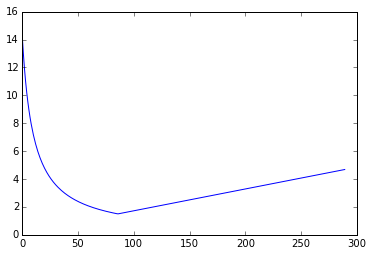

In [12]:
plot(ac.t_to_w_req)

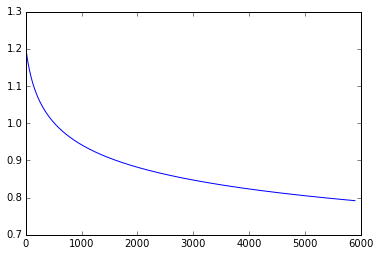

In [13]:
plot(ac.size(mission))

In [15]:
ac.engine.max_mach

6.185484200891787

In [10]:
ac.engine.__dict__

{'afterburner': False,
 'alphas': [1, 1.0, 0.952, 0.3, 0.4, 2.0, 0.7],
 'bpr': 1.0,
 'engine_type': 'ATJ',
 'k_sfc': 1.0,
 'k_size': 1.0,
 'k_w': 1.0,
 'max_mach': 6.185484200891787,
 'max_thrust': 6705.5203448617995,
 'name': 'Advanced Turbo-Jet (with afterburner)'}